## 1. BERT model
In this tutorial, we will use the BERT model for sentiment analysis task.

The dataset can be downloaded from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
# Install necessary packages
# !pip install pandas torch transformers scikit-learn matplotlib

In [1]:
# Import libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW #Improved version of the Adam optimizer
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm #Progress bar

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the dataset (use the first 100 rows)
df = pd.read_csv("IMDBDataset.csv").head(100)

# Encode sentiment labels to numerical values
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [5]:
# Define custom dataset
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [6]:
# Tokenize and split dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = IMDBDataset(df['review'].tolist(), df['sentiment'].tolist(), tokenizer)

# Split: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Initialize BERT model for classification, different versions: bert-base-cased, bert-large-uncased, bert-large-cased
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Training loop
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward() #Compute gradient
        optimizer.step() #Update weights

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)
    print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Accuracy = {train_accuracies[-1]:.4f}")

100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 1: Loss = 0.6936, Accuracy = 0.5875


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 2: Loss = 0.6342, Accuracy = 0.6500


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 3: Loss = 0.5524, Accuracy = 0.8000


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 4: Loss = 0.4765, Accuracy = 0.7875


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 5: Loss = 0.3749, Accuracy = 0.9375


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 6: Loss = 0.2820, Accuracy = 0.9750


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 7: Loss = 0.2057, Accuracy = 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 8: Loss = 0.1423, Accuracy = 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 9: Loss = 0.1109, Accuracy = 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

Epoch 10: Loss = 0.0831, Accuracy = 1.0000


In [9]:
# Save trained model
torch.save(model.state_dict(), "bert_imdb_model.pt")

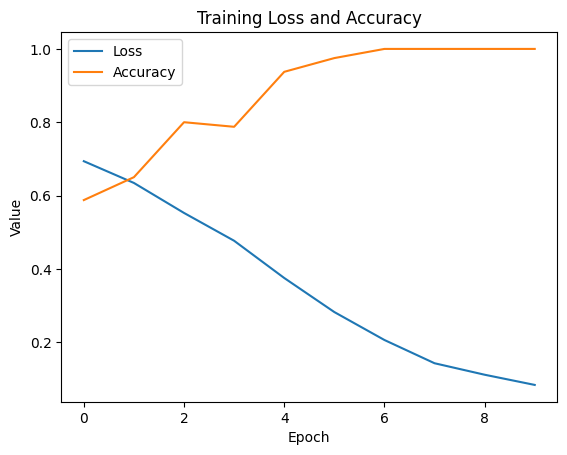

In [10]:
# Plot loss and accuracy curves
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

In [15]:
# Load the model for inference
model_loaded = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_loaded.load_state_dict(torch.load("bert_imdb_model.pt"))
model_loaded.to(device)
model_loaded.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Define prediction function
def predict(texts):
    #Converts raw text into token IDs that the model understands.
    #Return the result as PyTorch tensors (pt = PyTorch).
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model_loaded(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    return label_encoder.inverse_transform(preds.cpu().numpy())

In [17]:
# Try prediction on sample sentences
examples = [
    "I really enjoyed this movie, it was fantastic!",
    "What a waste of time. Terrible acting and plot.",
    "Not bad, but could have been better."
]
predictions = predict(examples)
for sentence, sentiment in zip(examples, predictions):
    print(f"Sentence: {sentence}\nPredicted Sentiment: {sentiment}\n")

Sentence: I really enjoyed this movie, it was fantastic!
Predicted Sentiment: positive

Sentence: What a waste of time. Terrible acting and plot.
Predicted Sentiment: negative

Sentence: Not bad, but could have been better.
Predicted Sentiment: negative



### Evaluate the model on the test set

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = total_loss / len(test_loader)
    test_accuracy = correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Run evaluation
evaluate_model(model_loaded, test_loader)

100%|██████████| 2/2 [00:00<00:00,  4.89it/s]

Test Loss: 0.3168, Test Accuracy: 0.8000


#### Compare different pre-trained models


Option 1: DistilBERT (Faster, Smaller)

In [22]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Initialize DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

# Load the dataset (use the first 100 rows)
df = pd.read_csv("IMDBDataset.csv").head(100)

# Encode sentiment labels to numerical values
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
# Training loop
epochs = 10
train_losses = []
train_accuracies = []

# Define custom dataset
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Tokenize and split dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = IMDBDataset(df['review'].tolist(), df['sentiment'].tolist(), tokenizer)

# Split: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward() #Compute gradient
        optimizer.step() #Update weights

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)
    print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Accuracy = {train_accuracies[-1]:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Epoch 1: Loss = 0.6928, Accuracy = 0.4625


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Epoch 2: Loss = 0.7001, Accuracy = 0.4250


100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Epoch 3: Loss = 0.6936, Accuracy = 0.4375


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Epoch 4: Loss = 0.6918, Accuracy = 0.4875


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Epoch 5: Loss = 0.6948, Accuracy = 0.4875


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Epoch 6: Loss = 0.6896, Accuracy = 0.5625


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 7: Loss = 0.6915, Accuracy = 0.4875


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 8: Loss = 0.6969, Accuracy = 0.4750


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Epoch 9: Loss = 0.6917, Accuracy = 0.5000


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

Epoch 10: Loss = 0.6932, Accuracy = 0.5375


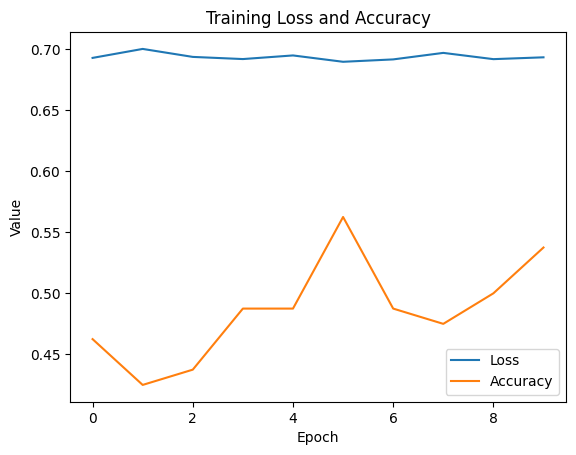

In [23]:
# Plot loss and accuracy curves
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

In [24]:
# Save trained model
torch.save(model.state_dict(), "Distilbert_imdb_model.pt")

Option 2: RoBERTa (More Robust)

In [26]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Load the dataset (use the first 100 rows)
df = pd.read_csv("IMDBDataset.csv").head(100)

# Encode sentiment labels to numerical values
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
# Training loop
epochs = 10
train_losses = []
train_accuracies = []

# Define custom dataset
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Tokenize and split dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = IMDBDataset(df['review'].tolist(), df['sentiment'].tolist(), tokenizer)

# Split: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward() #Compute gradient
        optimizer.step() #Update weights

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)
    print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Accuracy = {train_accuracies[-1]:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 1: Loss = 0.7120, Accuracy = 0.5000


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 2: Loss = 0.6940, Accuracy = 0.5875


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 3: Loss = 0.6797, Accuracy = 0.5875


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 4: Loss = 0.6756, Accuracy = 0.5875


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 5: Loss = 0.6615, Accuracy = 0.6000


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 6: Loss = 0.6882, Accuracy = 0.5875


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 7: Loss = 0.6724, Accuracy = 0.5875


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 8: Loss = 0.6675, Accuracy = 0.6250


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 9: Loss = 0.6793, Accuracy = 0.5625


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

Epoch 10: Loss = 0.6259, Accuracy = 0.6000


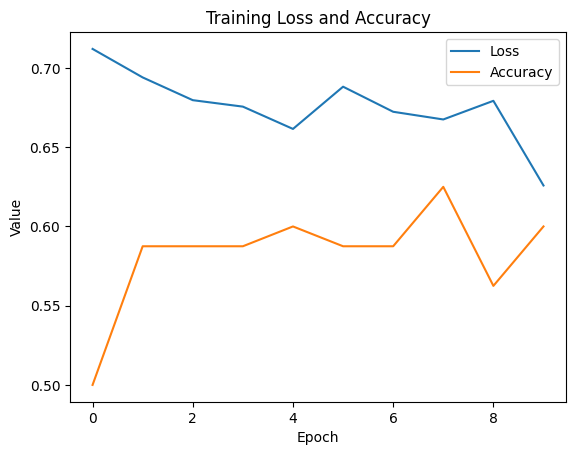

In [27]:
# Plot loss and accuracy curves
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()